# Batch analysis across mice & regions

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from interpolators import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Parameters

In [4]:
# Mouse line
mouseline = 'line3'
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation 

### Load data

In [5]:
dataroot = get_data_root()
data_dir = os.path.join(dataroot, mouseline)
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')

trialavg_root
KalmanFilter
# kalman_gain = KALMAN_GAIN  # gain of Kalman filter
# baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
# baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation 
# ykey_postpro = Label.ZSCORE  # Reference variable for post-processing  

# logger.info(f'loading data from {trialavg_dir}:')
# data = load_mousereg_datasets(trialavg_dir)
# timeseries = data['timeseries']
# stats = data['stats']
# stats

'/Users/tlemaire/Documents/data/usnm/trial-averaged/'

### Breakdown per mouse region

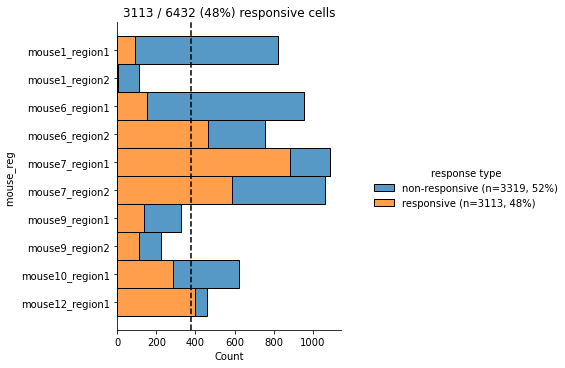

In [6]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

### Exclude datasets with low cell count

 17/05/2022 17:48:10: excluding ['mouse9_region1', 'mouse9_region2', 'mouse1_region2'] datasets from analysis


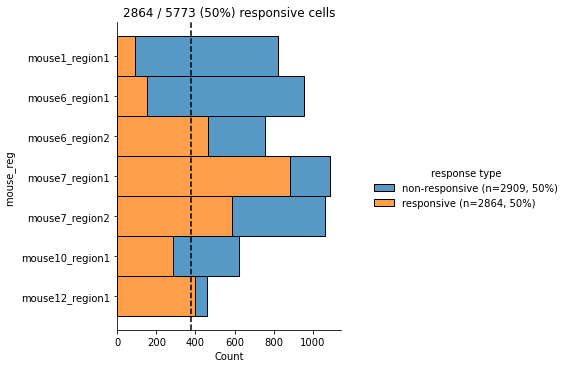

In [7]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.MOUSEREG, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.MOUSEREG).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

## Parameter dependency curves

### Plotting function

In [27]:
def plot_paramsdeps(
    stats, ykey, stimparams=[Label.P, Label.DC], ythr=None, nposthr=None,
    weighted=True, **kwargs):

    # Determine variable of interest for output metrics
    ykey_resp = f'diff {ykey}'
    if ythr is None:
        ythr = {Label.ZSCORE: pvalue_to_zscore(PTHR_DETECTION), Label.DFF: .1}[ykey]

    # Re-classify stats according to new criterion, if specified
    if ythr is not None or nposthr is not None:
        stats = reclassify(stats.copy(), ykey_resp, ythr=ythr, nposthr=nposthr)

    # Determine plot parameters
    if not is_iterable(stimparams):
        stimparams = [stimparams]
    weighted = [True, False] if weighted == 'both' else [weighted]
    ybounds = {Label.ZSCORE: (-.5, 4.5), Label.DFF: None}[ykey]
    
    # For each stimulus parameters 
    for xkey in stimparams:
        # For each weighting type
        for w in weighted:
            wstr = {True: '', False: 'non-'}[w] + 'weighted'
            # Plot parameter dependency across cell types
            fig = plot_parameter_dependency_across_datasets(
                stats, xkey, ykey_resp, weighted=w,
                baseline=[0., ythr], ybounds=ybounds, height=4, aspect=1., 
                hide_col_prefix=True, col_count_key=[Label.MOUSEREG, Label.ROI],
                **kwargs)
            # Add re-classification info to title
            suffix = []
            if nposthr is not None:
                suffix.append(f'nposthr = {nposthr}')
            if ythr is not None:
                suffix.append(f'ythr = {ythr:.2f}')
            if len(suffix) > 0:
                ttl = fig._suptitle.get_text()
                fig.suptitle(f'{ttl} [{", ".join(suffix)}]')
            # Add figure to figures dictionary
            figs[f'{ykey_resp} vs {xkey} {wstr}'] = fig

### Default dependency curves

 17/05/2022 18:12:48: sub-indexing data...
 17/05/2022 18:12:48: filtering data...
 17/05/2022 18:12:48: cross-checking filters...
 17/05/2022 18:12:48: grouping by response type, grouping by mouse_reg, averaging and plotting mean diff ΔF/F0 vs. P (MPa) ...
 17/05/2022 18:12:49: sub-indexing data...
 17/05/2022 18:12:49: filtering data...
 17/05/2022 18:12:49: cross-checking filters...
 17/05/2022 18:12:49: grouping by response type, grouping by mouse_reg, averaging and plotting mean diff ΔF/F0 vs. DC (%) ...


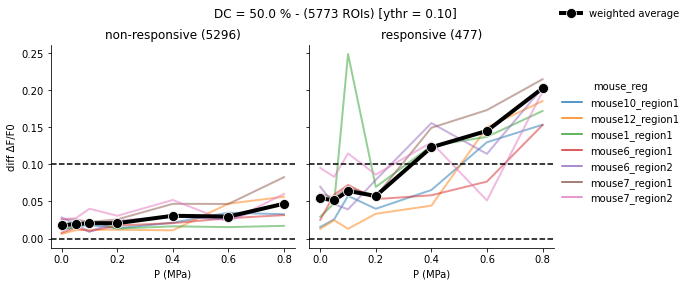

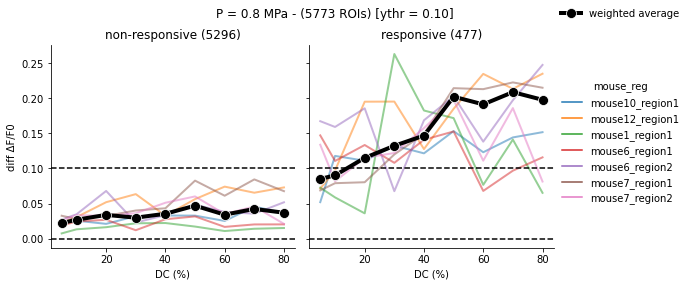

In [28]:
plot_paramsdeps(stats, Label.DFF, show_datasets=True)

### Influence of detection threshold

 17/05/2022 18:11:48: sub-indexing data...
 17/05/2022 18:11:48: filtering data...
 17/05/2022 18:11:48: cross-checking filters...
 17/05/2022 18:11:48: grouping by response type, grouping by mouse_reg, averaging and plotting mean post-stim Z(ΔF/F0) vs. P (MPa) ...
 17/05/2022 18:11:49: sub-indexing data...
 17/05/2022 18:11:49: filtering data...
 17/05/2022 18:11:49: cross-checking filters...
 17/05/2022 18:11:49: grouping by response type, grouping by mouse_reg, averaging and plotting mean post-stim Z(ΔF/F0) vs. P (MPa) ...
 17/05/2022 18:11:50: sub-indexing data...
 17/05/2022 18:11:50: filtering data...
 17/05/2022 18:11:50: cross-checking filters...
 17/05/2022 18:11:50: grouping by response type, grouping by mouse_reg, averaging and plotting mean post-stim Z(ΔF/F0) vs. P (MPa) ...
 17/05/2022 18:11:50: sub-indexing data...
 17/05/2022 18:11:50: filtering data...
 17/05/2022 18:11:50: cross-checking filters...
 17/05/2022 18:11:50: grouping by response type, grouping by mouse_reg,

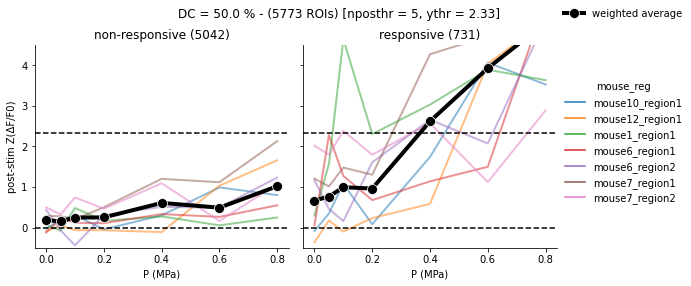

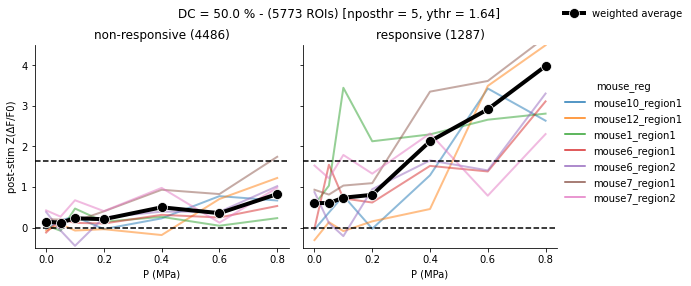

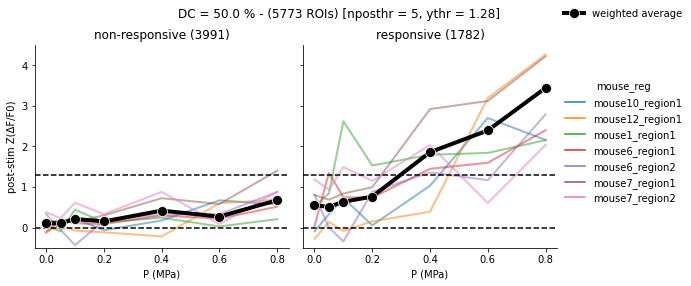

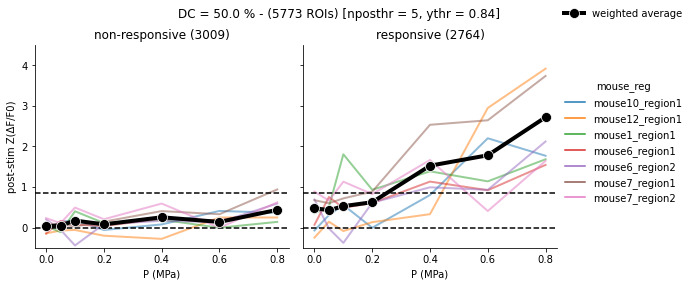

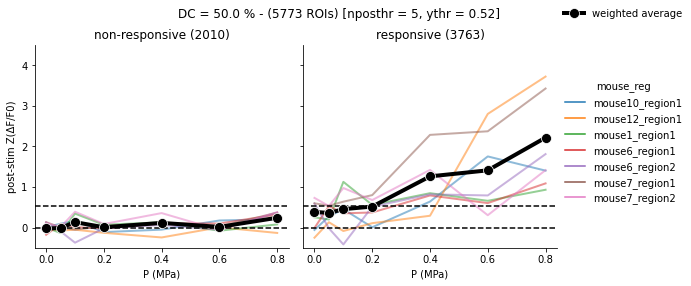

In [26]:
for pthr in [.01, .05, .1, .2, .3]:
    zthr = pvalue_to_zscore(pthr)
    plot_paramsdeps(
        stats, Label.ZSCORE, stimparams=Label.P, ythr=zthr, nposthr=5)

### Influence of threshold number of positive conditions

 17/05/2022 16:46:46: sub-indexing data...
 17/05/2022 16:46:46: filtering data...
 17/05/2022 16:46:46: cross-checking filters...
 17/05/2022 16:46:46: grouping by response type, grouping by mouse_reg, averaging and plotting mean average Z(ΔF/F0) vs. P (MPa) ...
 17/05/2022 16:46:47: sub-indexing data...
 17/05/2022 16:46:47: filtering data...
 17/05/2022 16:46:47: cross-checking filters...
 17/05/2022 16:46:47: grouping by response type, grouping by mouse_reg, averaging and plotting mean average Z(ΔF/F0) vs. P (MPa) ...
 17/05/2022 16:46:48: sub-indexing data...
 17/05/2022 16:46:48: filtering data...
 17/05/2022 16:46:48: cross-checking filters...
 17/05/2022 16:46:48: grouping by response type, grouping by mouse_reg, averaging and plotting mean average Z(ΔF/F0) vs. P (MPa) ...
 17/05/2022 16:46:49: sub-indexing data...
 17/05/2022 16:46:49: filtering data...
 17/05/2022 16:46:49: cross-checking filters...
 17/05/2022 16:46:49: grouping by response type, grouping by mouse_reg, avera

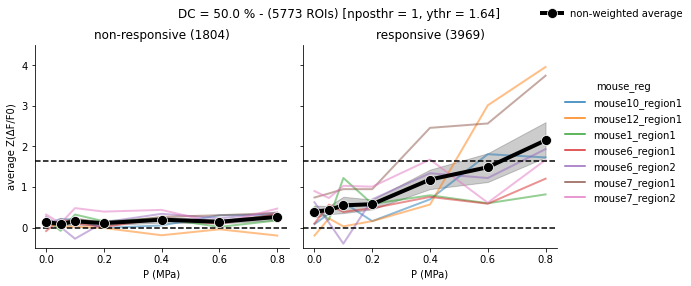

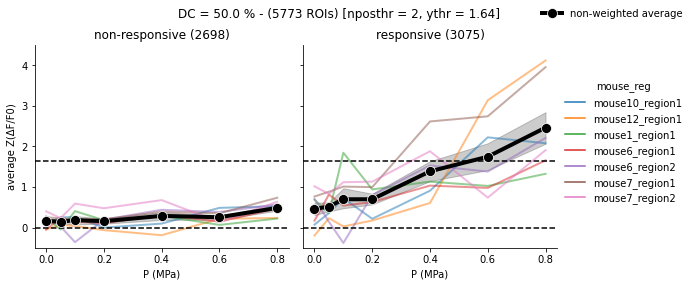

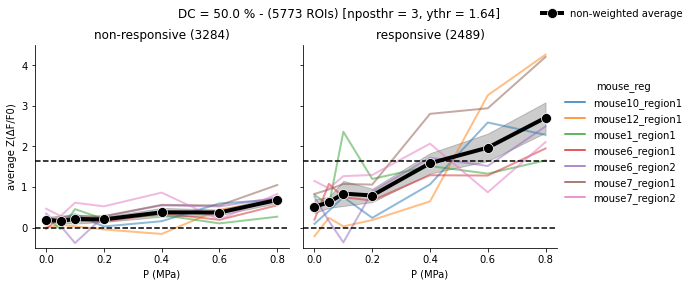

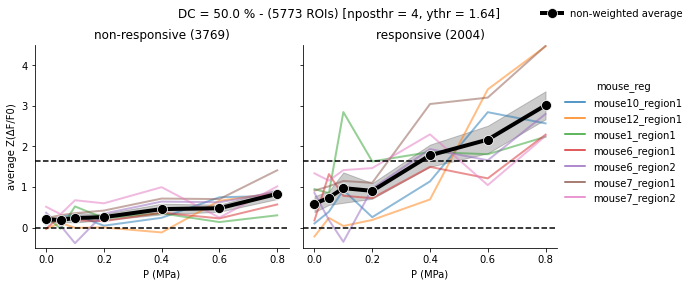

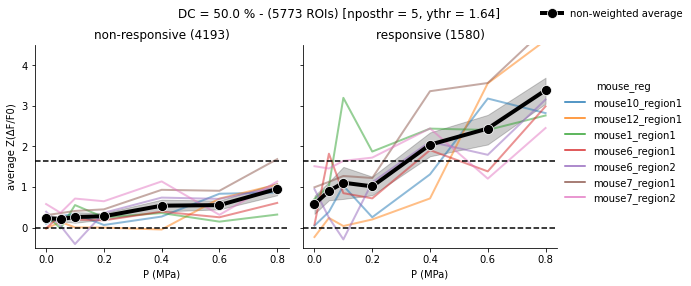

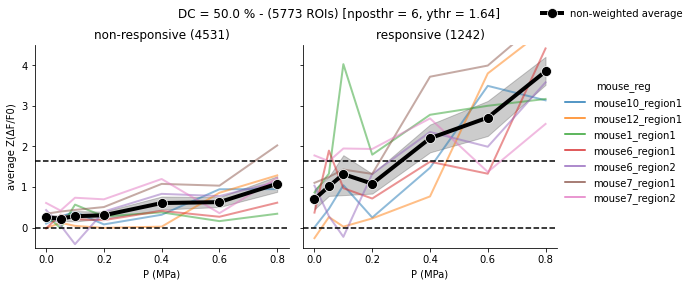

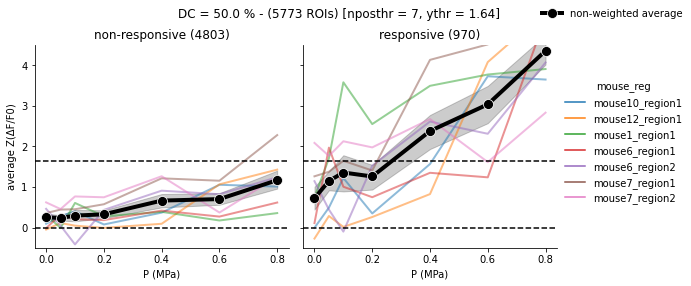

In [10]:
zthr = pvalue_to_zscore(PTHR_DETECTION)
for n in np.arange(7) + 1:
    plot_paramsdeps(
        stats, Label.ZSCORE, stimparams=Label.P, ythr=zthr, nposthr=n)

## Traces

In [11]:
plt_data = get_plot_data(timeseries, stats)

 17/05/2022 16:46:53: merging timeseries and stats information...
 17/05/2022 16:47:16: adding time info to table...


 17/05/2022 16:47:22: plotting dependency curves for non-responsive cells...
 17/05/2022 16:47:22: sub-indexing data...
 17/05/2022 16:47:24: filtering data...
 17/05/2022 16:47:24: cross-checking filters...
 17/05/2022 16:47:25: grouping by mouse_reg, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...
 17/05/2022 16:48:08: plotting dependency curves for responsive cells...
 17/05/2022 16:48:08: sub-indexing data...
 17/05/2022 16:48:09: filtering data...
 17/05/2022 16:48:09: cross-checking filters...
 17/05/2022 16:48:10: grouping by mouse_reg, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) vs. time (s) ...


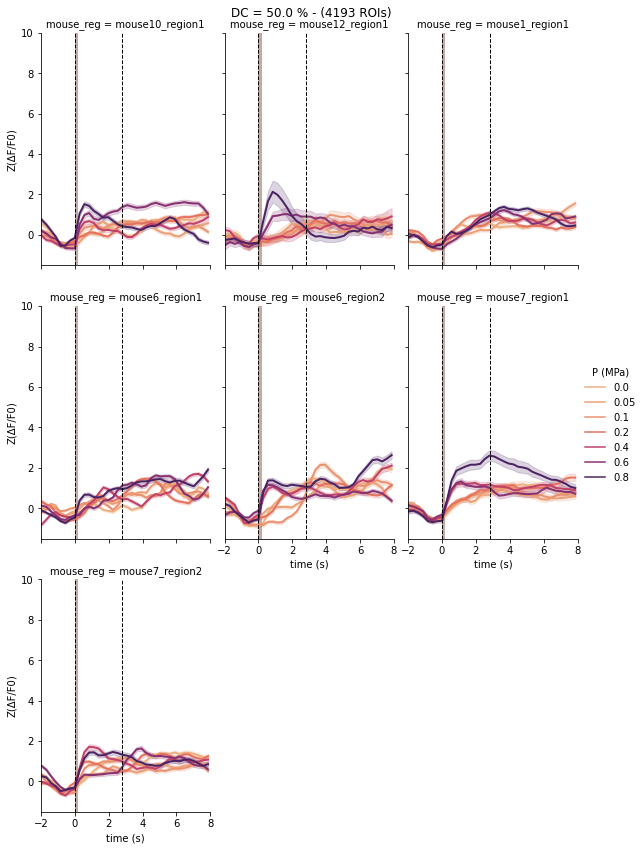

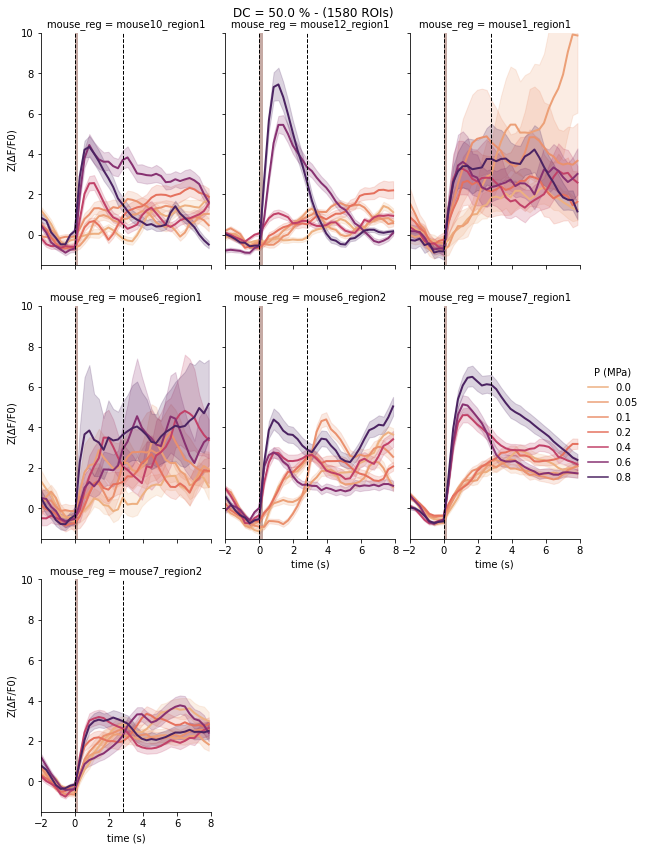

In [12]:
ykey = Label.ZSCORE

tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-1.5, 10.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

for resptype, group in plt_data.groupby(Label.ROI_RESP_TYPE):
    logger.info(f'plotting dependency curves for {resptype} cells...')
    # Pressure dependency
    figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
        group, ykey=ykey, DC=DC_REF, hue=Label.P, 
        col=Label.MOUSEREG, max_colwrap=3, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

In [13]:
# Copy data and remove run index
avg_plt_data = plt_data.copy().droplevel(Label.RUN)
# Generate new run index from (P, DC) combination 
tmp1 = avg_plt_data[Label.P].map('{:.2f}MPa'.format)
tmp2 = avg_plt_data[Label.DC].map('{:.0f}%DC'.format)
avg_plt_data[Label.RUN] = tmp1 + tmp2
avg_plt_data.set_index(Label.RUN, append=True, inplace=True)
# Group data by mouse-region, response type, run and frame -> average
avg_plt_data = avg_plt_data.groupby(
    [Label.MOUSEREG, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR])

In [14]:
avg_plt_data2 = avg_plt_data.loc[:, [
    Label.P,
    Label.DC,
    Label.DUR,
    Label.TIME,
    Label.DFF,
    Label.ZSCORE
]]
avg_plt_data2

P (MPa)  DC (%)  \
mouse_reg       response type  run          frame                    
mouse10_region1 non-responsive 0.00MPa50%DC 0          0.0    50.0   
                                            1          0.0    50.0   
                                            2          0.0    50.0   
                                            3          0.0    50.0   
                                            4          0.0    50.0   
...                                                    ...     ...   
mouse7_region2  responsive     0.80MPa80%DC 95         0.8    80.0   
                                            96         0.8    80.0   
                                            97         0.8    80.0   
                                            98         0.8    80.0   
                                            99         0.8    80.0   

                                                   duration (s)   time (s)  \
mouse_reg       response type  run          frame                            
mouse10_region1 non-responsive 0.00MPa50%DC 0               0.2  -2.808989   
                                            1               0.2  -2.528090   
                                            2               0.2  -2.247191   
                                            3               0.2  -1.966292   
                                            4               0.2  -1.685393   
...                                                         ...        ...   
mouse7_region2  responsive     0.80MPa80%DC 95              0.2  23.876404   
                                            96              0.2  24.157303   
                                            97              0.2  24.438202   
                                            98              0.2  24.719101   
                                            99              0.2  25.000000   

                                                      ΔF/F0  Z(ΔF/F0)  
mouse_reg       response type  run          frame                      
mouse10_region1 non-responsive 0.00MPa50%DC 0      0.105361 -0.013989  
                                            1      0.111344  0.306578  
                                            2      0.116318  0.589472  
                                            3      0.115157  0.550136  
                                            4      0.111835  0.386943  
...                                                     ...       ...  
mouse7_region2  responsive     0.80MPa80%DC 95     0.187705  2.819680  
                                            96     0.189841  2.862763  
                                            97     0.188244  2.777900  
                                            98     0.182922  2.649863  
                                            99     0.177301  2.421448  

[21000 rows x 6 columns]

 17/05/2022 16:48:59: sub-indexing data...
 17/05/2022 16:48:59: filtering data...
 17/05/2022 16:48:59: cross-checking filters...
 17/05/2022 16:48:59: grouping by response type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


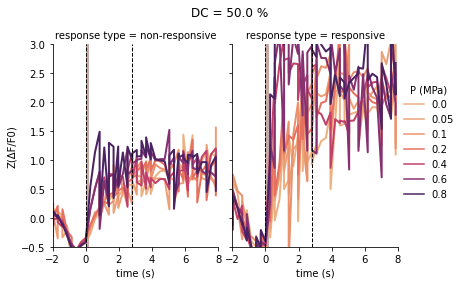

In [15]:
tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-.5, 3.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

# Pressure dependency
figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
    avg_plt_data2, ykey=ykey, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, ci=None, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

### Save figures

In [16]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix='global')

 17/05/2022 16:48:59: saving figure "rtype dist per mousereg" on page 0
 17/05/2022 16:48:59: saving figure "average Z(ΔF/F0) vs P (MPa) non-weighted" on page 1
 17/05/2022 16:48:59: saving figure "average Z(ΔF/F0) vs DC (%) non-weighted" on page 2
 17/05/2022 16:48:59: saving figure "responses Z(ΔF/F0) by type DC=50.0%" on page 3
